In [1]:
import os 
from dotenv import load_dotenv
load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
groq_api_key = os.getenv('GROQ_API_KEY')

from langchain_groq import ChatGroq
llm = ChatGroq(model="openai/gpt-oss-120b", api_key=groq_api_key)
llm.invoke("hello world")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'reasoning_content': 'The user says "hello world". Probably they just want a greeting. So respond accordingly.'}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 73, 'total_tokens': 110, 'completion_time': 0.073705476, 'prompt_time': 0.00265898, 'queue_time': 0.04766615, 'total_time': 0.076364456}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e10890e4b9', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--19c1ff91-6bd9-4ef4-a8c5-d1d86b954d42-0', usage_metadata={'input_tokens': 73, 'output_tokens': 37, 'total_tokens': 110})

In [3]:
from typing import Annotated, List
from typing_extensions import TypedDict, Literal
from pydantic import BaseModel, Field

class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [4]:
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(description="decide if the joke is funny or not.")
    feedback: str = Field(description="If the joke is not funny, provide feedback on how to improve it.")

evaluator = llm.with_structured_output(Feedback)

In [6]:
def llm_call_generator(state:State):
    """LLM generate a joke"""
    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into the account the feedback: {state["feedback"]}"
            )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke":msg.content}

def llm_call_evaluator(state:State):
    """ LLM evaluates the joke"""
    grade = evaluator.invoke(f"Grade the joke: {state["joke"]}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

def route_joke(state:State):
    """Route back to joke generator or endbased upon feedback from the evaluator"""
    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


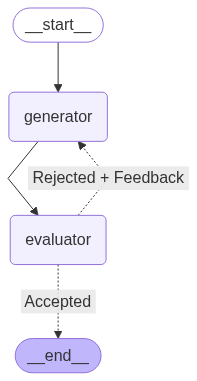

In [7]:
from langgraph.graph import StateGraph, START,END
from IPython.display import display, Image

optimizer_builder = StateGraph(State)
optimizer_builder.add_node("generator", llm_call_generator)
optimizer_builder.add_node("evaluator", llm_call_evaluator)

optimizer_builder.add_edge(START, "generator")
optimizer_builder.add_edge("generator", "evaluator")
optimizer_builder.add_conditional_edges("evaluator", route_joke, {"Accepted":END, "Rejected + Feedback":"generator"})
graph = optimizer_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
graph.invoke({"topic": "gay"})['joke']

'**Setup:** Why did the gay Wi‑Fi network always get the best reception at parties?  \n\n**Punchline:** Because it’s always broadcasting in full rainbow‑mode, and everyone knows it’s got a strong signal for “coming out” and a flawless connection for “being fabulous”!'